## Imports

In [1]:
import os

# Set environment variables
os.environ["HF_HOME"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"
os.environ["HF_DATASETS_CACHE"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"
os.environ["TRANSFORMERS_CACHE"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"

# Verify the variables (optional)
print("HF_HOME:", os.environ.get("HF_HOME"))
print("HF_DATASETS_CACHE:", os.environ.get("HF_DATASETS_CACHE"))
print("TRANSFORMERS_CACHE:", os.environ.get("TRANSFORMERS_CACHE"))

HF_HOME: /home/hice1/kpereira6/scratch/ConvAI/hf_cache
HF_DATASETS_CACHE: /home/hice1/kpereira6/scratch/ConvAI/hf_cache
TRANSFORMERS_CACHE: /home/hice1/kpereira6/scratch/ConvAI/hf_cache


In [2]:
from transformers import SamModel, SamProcessor
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import torch
from sklearn.manifold import MDS
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import random

/home/hice1/kpereira6/.conda/envs/cAI8803-gpu/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Load Model

#### SAM

In [3]:
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

#add to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

### Load Data

In [4]:
folders = os.listdir('./numerosity_project - All Stimuli')

In [5]:
folders

['Natural images plain_bg',
 'Equal area triangles',
 'Natural images plain_bg_blurred',
 'Natural images dinner',
 'Random shape random area',
 '.DS_Store',
 'Natural images',
 'Equal circumference circles',
 'Equal area squares',
 'Stimuli generation guide.docx',
 'Equal area circles',
 'Natural images dinner_blurred']

### Utils

In [6]:
def get_a_random_pic(folder_name,numerosity):
    #randomly choose an image of particular numerosity from any area/circumference for a class
    candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}')
    folder_id = np.random.choice(candidates)
    folder_path = f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}/{folder_id}/{numerosity}'
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}/{folder_id}/{numerosity}/'+ pic


In [7]:
def distance_effect(dist_matrix):
    print("\n\nDistance Effect")

    # 1: Distance Effect
    diff = defaultdict(list)

    # Get diff
    for i in range(0, 9):
        for j in range(i+1, 9):
            key = abs(i-j)
            diff[key].append(1 - dist_matrix[i][j])

    # Average
    for keys in diff:
        diff[keys] = np.mean(diff[keys])

    X = np.array([i for i in range(1, 9)])
    Y = np.array([diff[i] for i in range(1, 9)])

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.figure(figsize=(10, 6))
    plt.xlabel("Numerical Difference between two numerosties |n1-n2|")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    # Fit a line
    params = linregress(X, Y)
    slope, intercept = params.slope, params.intercept
    y_pred = slope * X + intercept

    fig, ax = plt.subplots()
    ax.scatter(X, Y, label='Data Points', color='blue')
    ax.plot(X, y_pred, label='Linear Fit', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    # Print fitted parameters
    print("Fitted parameters:")
    print('Slope', slope)
    print('Intercept', intercept)

In [8]:
def size_effect(dist_matrix):
    print("\n\nSize Effect")

    # 2: Size Effect
    X = []
    Y = []

    size = defaultdict(list)
    for i in range(1, 10):
        for j in range(i+1, 10):
            key = (i+j) // 2
            size[key].append(1 - dist_matrix[i-1][j-1])

    # Average
    for keys in size:
        size[keys] = np.mean(size[keys])

    X = np.array(sorted(size.keys()))  # Sizes (average magnitude)
    Y = np.array([size[key] for key in X])

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.figure(figsize=(10, 6))
    plt.xlabel("Size (n1+n2)/2")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    params = linregress(X, Y)
    slope, intercept = params.slope, params.intercept
    y_pred = slope * X + intercept

    fig, ax = plt.subplots()
    ax.scatter(X, Y, label='Data Points', color='blue')
    ax.plot(X, y_pred, label='Linear Fit', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    print("Fitted parameters:")
    print('Slope', slope)
    print('Intercept', intercept)


In [9]:
from scipy.optimize import curve_fit

def ratio_effect(dist_matrix):
    print("\n\nRatio Effect")

    # 3: Ratio Effect
    X = []
    Y = []
    for i in range(0, 9):
        for j in range(i+1, 9):
            X.append(max(i+1, j+1)/ min(i+1, j+1))
            Y.append(1 - dist_matrix[i][j])

    X = np.array(X)
    Y = np.array(Y)

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.xlabel("Max/Min")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    # Fit the curve (Exponential decay)
    params, covariance = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, X, Y, maxfev=1000000)

    # Extract fitted parameters
    a_fit, b_fit, c_fit = params
    y_pred = a_fit * np.exp(np.array(X)* - b_fit) + c_fit

    # Calculate R^2
    y_mean = np.mean(Y)
    ss_res = np.sum((Y - y_pred)**2)
    ss_tot = np.sum((Y - y_mean)**2)
    r_squared = 1 - (ss_res / ss_tot)

    print("R-squared value =", r_squared)

    # Plot the data points
    fig, ax = plt.subplots()
    plt.scatter(X, Y, label='Data Points', color='blue')

    # Plot the fitted curve
    x_fit = np.linspace(min(X), max(X), 100)
    y_fit = a_fit * np.exp(np.array(x_fit)* - b_fit) + c_fit
    plt.plot(x_fit, y_fit, label='Fitted Curve', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()


In [10]:
path = f"./numerosity_project - All Stimuli/"

### MDS

In [11]:
def handle_mds(M, category, n_comp = 1):
    plt.figure(figsize=(8, 6))
    if n_comp == 1:
        mds = MDS(n_components=1, dissimilarity="precomputed", random_state = 42)
        embedding = mds.fit_transform(M)
        stress = mds.stress_

        plt.scatter(embedding[:, 0], np.zeros_like(embedding[:, 0]), alpha=0.7, color='blue')
        for i in range(9):
            plt.text(embedding[i, 0], 0, f"{i+1}", fontsize=15, ha='right', va='center')
    elif n_comp == 2:
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state = 42)
        embedding = mds.fit_transform(M)
        stress = mds.stress_

        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.7, color='blue')
        for i in range(9):
            plt.text(embedding[i, 0], embedding[i, 1], f"{i+1}", fontsize=15, ha='right', va='center')

    plt.title(f"MDS Visualization for {category}:\nStress: {stress}")
    plt.xlabel("1D Embedding")
    plt.yticks([])
    plt.grid(True, axis='x')
    plt.show()

### Experiment 1

In [37]:
def get_a_random_pic_for_exp1(folder_id,numerosity):
    #folder_id -> area
    #randomly choose an image of particular numerosity from any area class
    #circle select two from same area
    # candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/Equal area circles')

    folder_path = f'./numerosity_project - All Stimuli/Equal area circles/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [38]:
get_a_random_pic_for_exp1('A1',1)

'./numerosity_project - All Stimuli/Equal area circles/A1/1/1_19.png'

In [39]:
def createNumerosityDistanceMatrix_Exp1(model, processor, device="cuda",M=20,Area='A2'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp1(Area,i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_embeddings(img_inputs["pixel_values"])[0]
                global_vector = img_embeddings.mean(dim=(1, 2))
            temp_vectors.append(global_vector.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [40]:
dist_matrix = createNumerosityDistanceMatrix_Exp1(model,processor)

(256,)




Distance Effect
Pearsons correlation: -0.9605622988011664
Fitted parameters:
Slope -0.00018797590568358
Intercept 1.0003125741824406


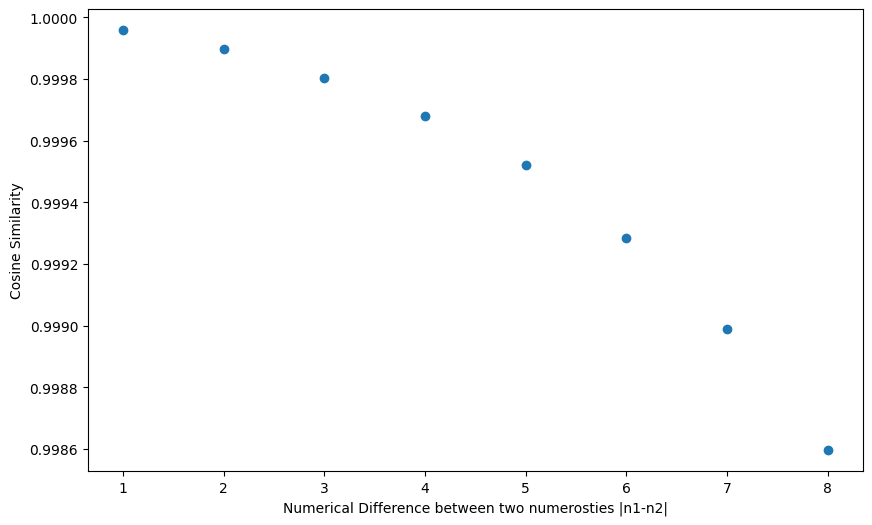

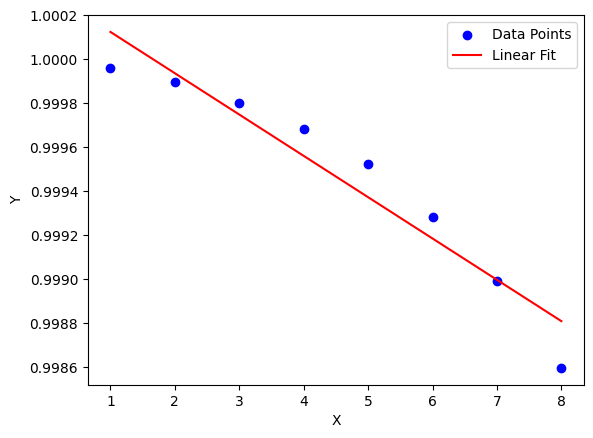

In [41]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.38042229499365654
Fitted parameters:
Slope 2.452444597706808e-05
Intercept 0.9996359042975367


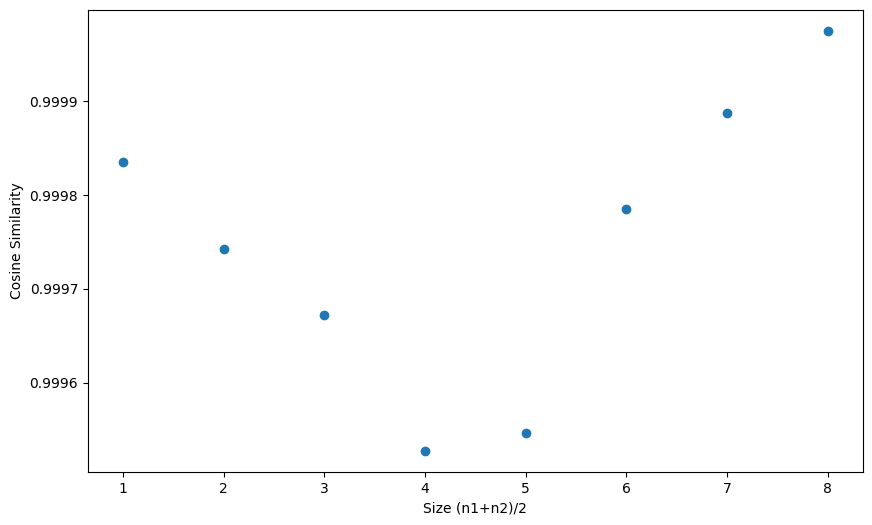

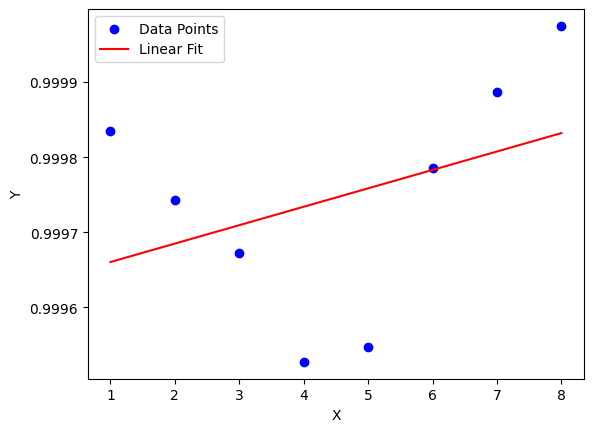

In [42]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.9832384126273098
R-squared value = 0.9667551465689904


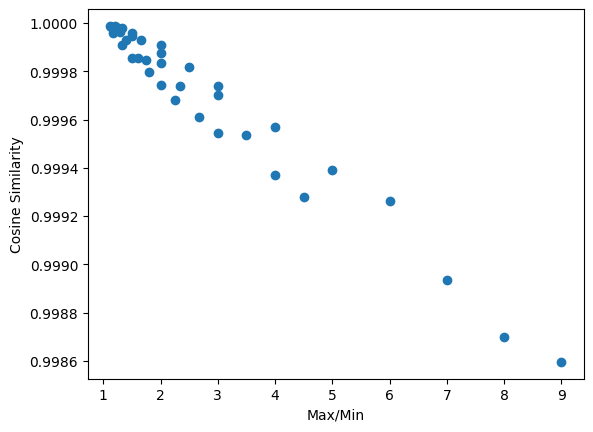

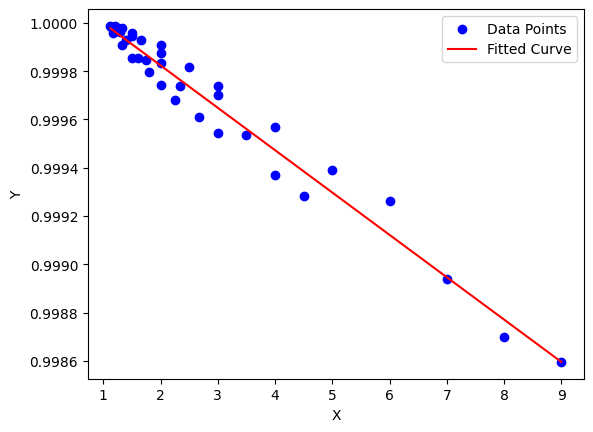

In [43]:
ratio_effect(dist_matrix)

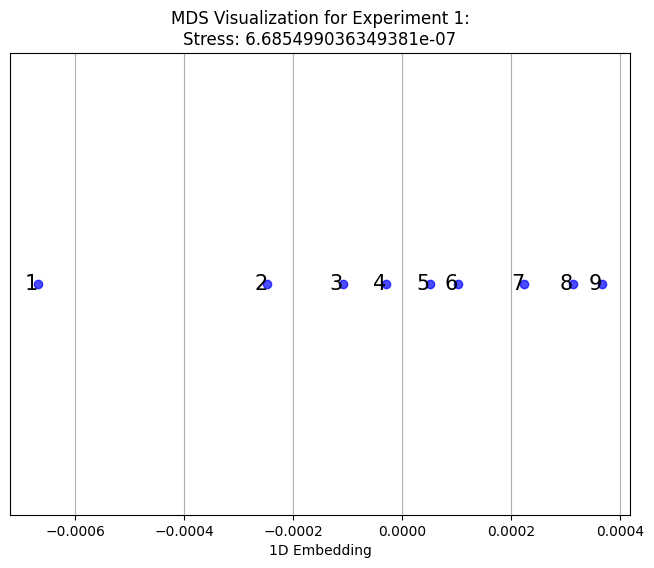

In [44]:
handle_mds(dist_matrix, "Experiment 1", n_comp = 1)

### Experiment 2

In [45]:
def get_a_random_pic_for_exp2(folder_id,numerosity):
    #folder_id -> area
    #randomly choose an image of particular numerosity from any area class
    #circle select two from same area
    # candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/Equal area circles')

    folder_path = f'./numerosity_project - All Stimuli/Equal circumference circles/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [46]:
def createNumerosityDistanceMatrix_Exp2(model, processor, device="cuda",M=20,C='C1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp2(C,i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_embeddings(img_inputs["pixel_values"])[0]
                global_vector = img_embeddings.mean(dim=(1, 2))
            temp_vectors.append(global_vector.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [47]:
dist_matrix = createNumerosityDistanceMatrix_Exp2(model,processor)

(256,)




Distance Effect
Pearsons correlation: -0.9840954556534687
Fitted parameters:
Slope -0.00010953823826750919
Intercept 1.000166802939509


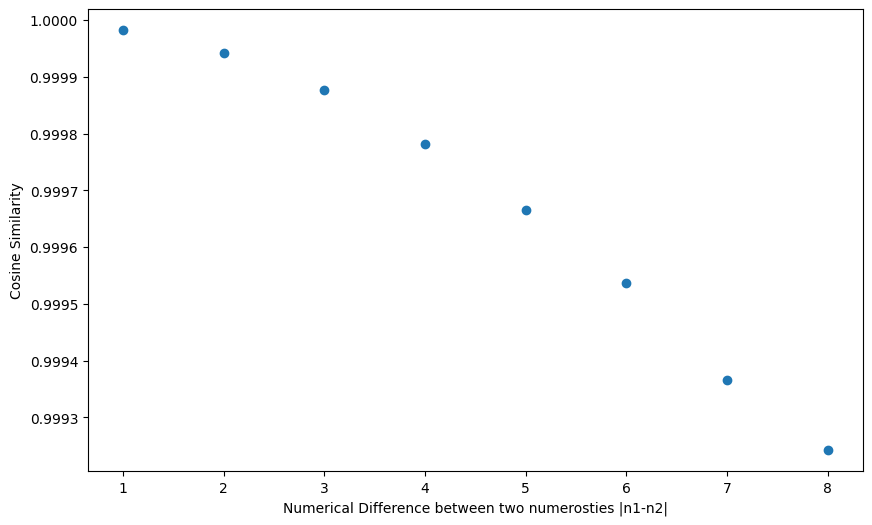

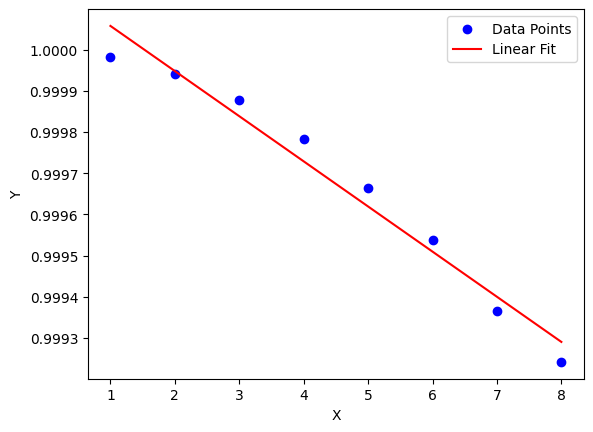

In [48]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: -0.01510766539626307
Fitted parameters:
Slope -7.136329974732902e-07
Intercept 0.9998582967842111


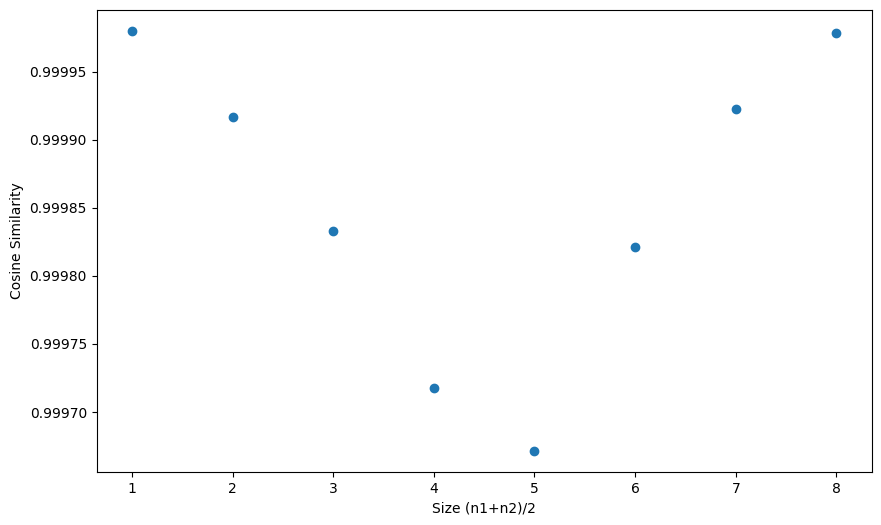

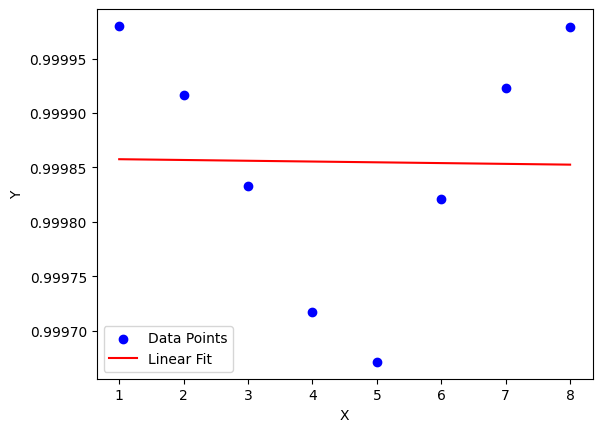

In [49]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.873420896356795
R-squared value = 0.7788651576264738


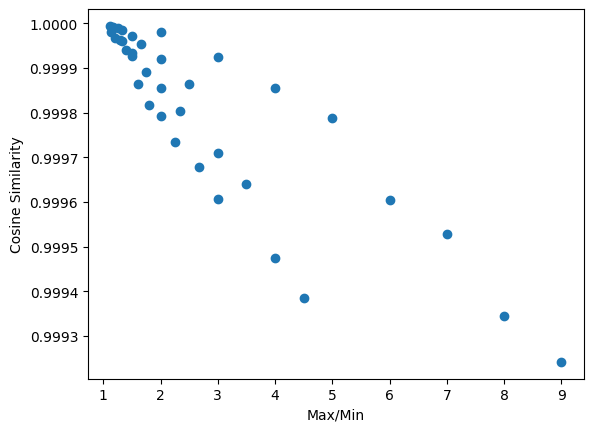

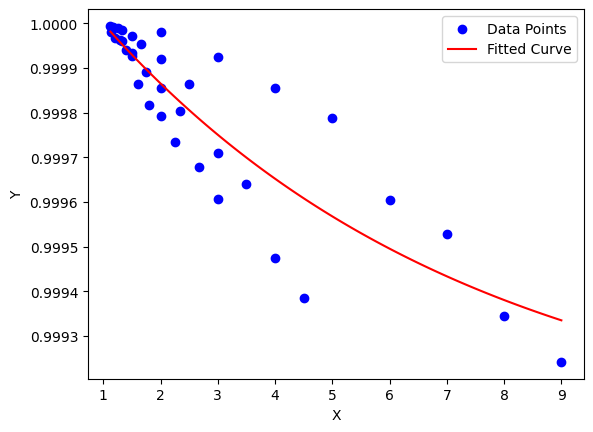

In [50]:
ratio_effect(dist_matrix)

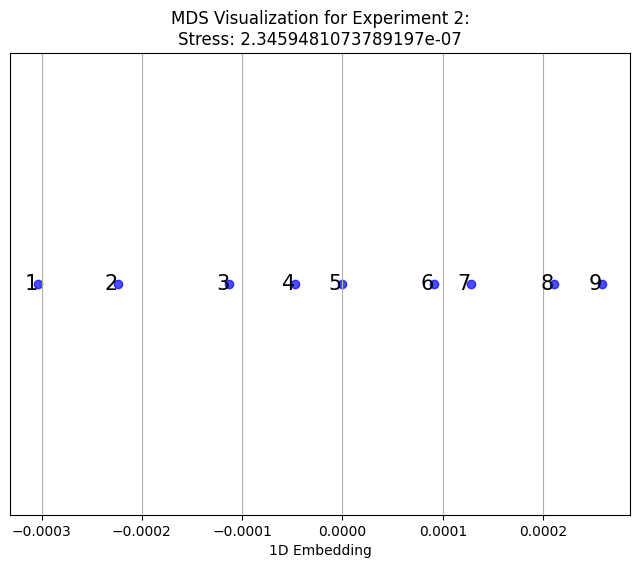

In [51]:
handle_mds(dist_matrix, "Experiment 2", n_comp = 1)

### Experiment 3

In [52]:
os.listdir('./numerosity_project - All Stimuli')

['Natural images plain_bg',
 'Equal area triangles',
 'Natural images plain_bg_blurred',
 'Natural images dinner',
 'Random shape random area',
 '.DS_Store',
 'Natural images',
 'Equal circumference circles',
 'Equal area squares',
 'Stimuli generation guide.docx',
 'Equal area circles',
 'Natural images dinner_blurred']

In [53]:
shapes = ['Equal area squares','Equal area circles','Equal area triangles']

In [54]:
def get_a_random_pic_for_exp3(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/{shape}/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [55]:
def createNumerosityDistanceMatrix_Exp3(model, processor, device="cuda",M=20,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    shape_dict = {i: random.choice(shapes) for i in range(1, 10)}

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp3(A,i,shape_dict[i])
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_embeddings(img_inputs["pixel_values"])[0]
                global_vector = img_embeddings.mean(dim=(1, 2))
            temp_vectors.append(global_vector.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [56]:
dist_matrix = createNumerosityDistanceMatrix_Exp3(model,processor)

(256,)




Distance Effect
Pearsons correlation: -0.9330918418700096
Fitted parameters:
Slope -0.0003624617495909863
Intercept 1.0001618131792465


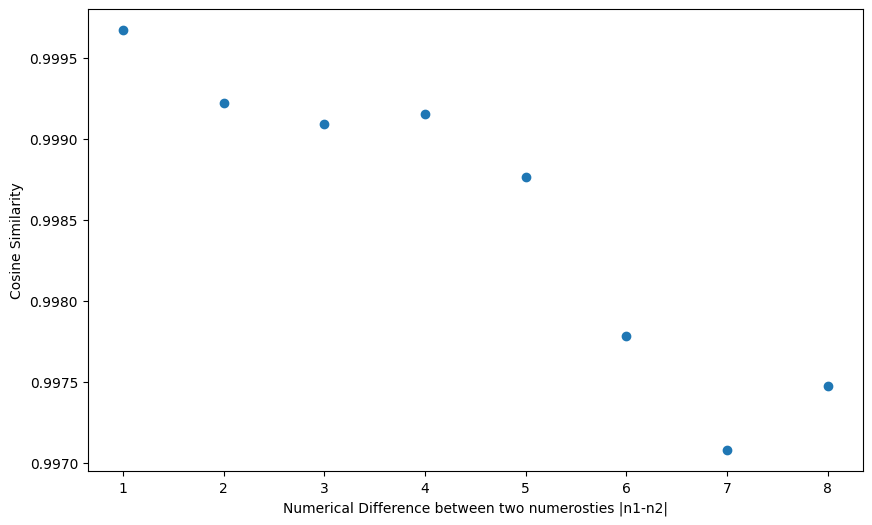

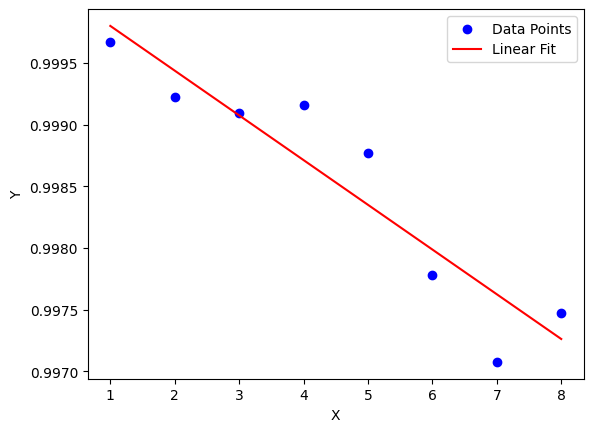

In [57]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: -0.4218198800611349
Fitted parameters:
Slope -0.00010779756469791484
Intercept 0.9996657289311189


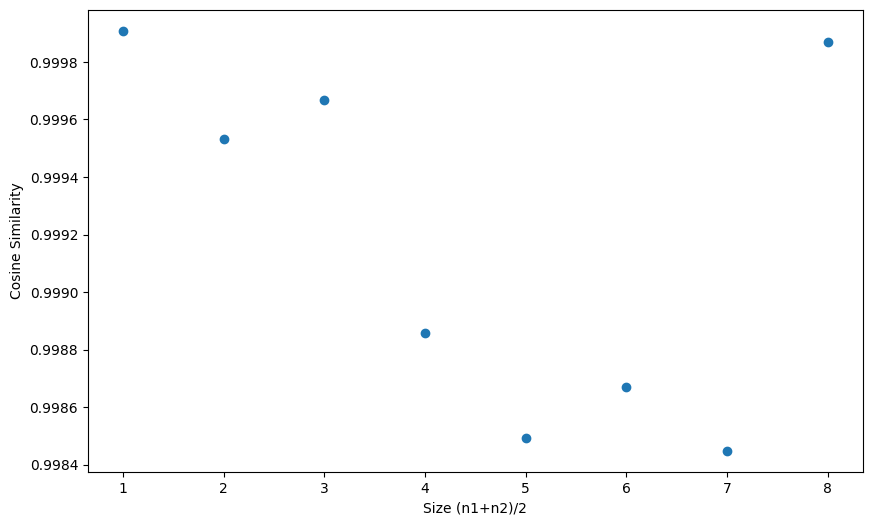

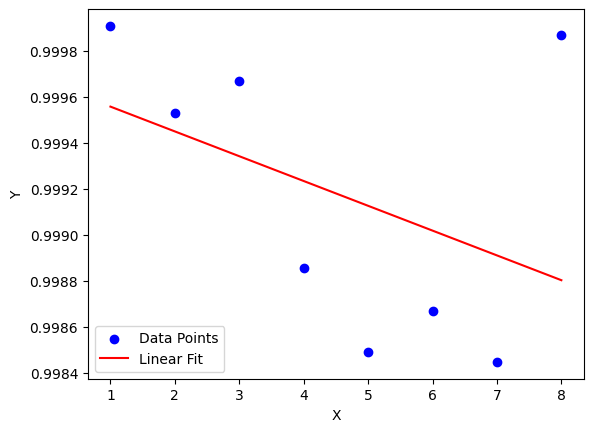

In [58]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.4662466772279626
R-squared value = 0.21738324059651104


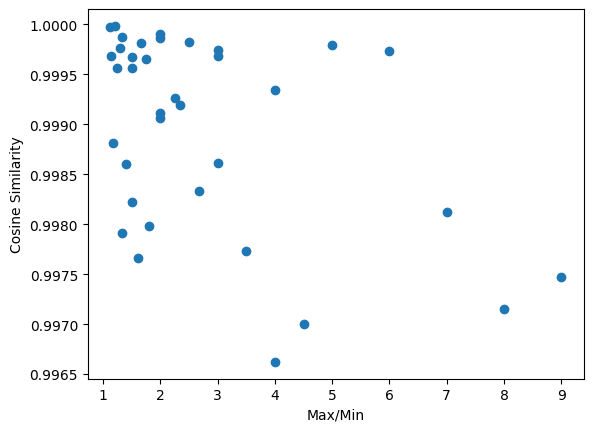

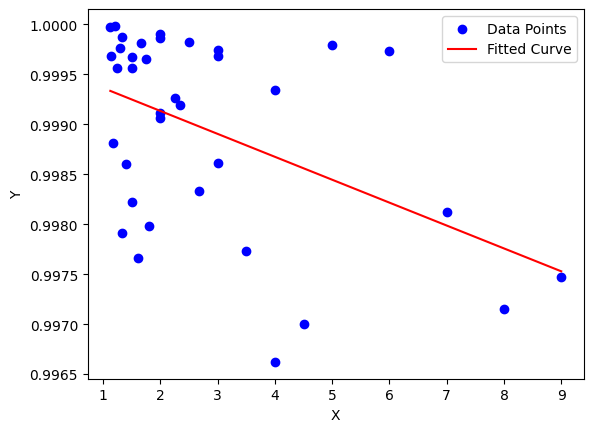

In [59]:
ratio_effect(dist_matrix)

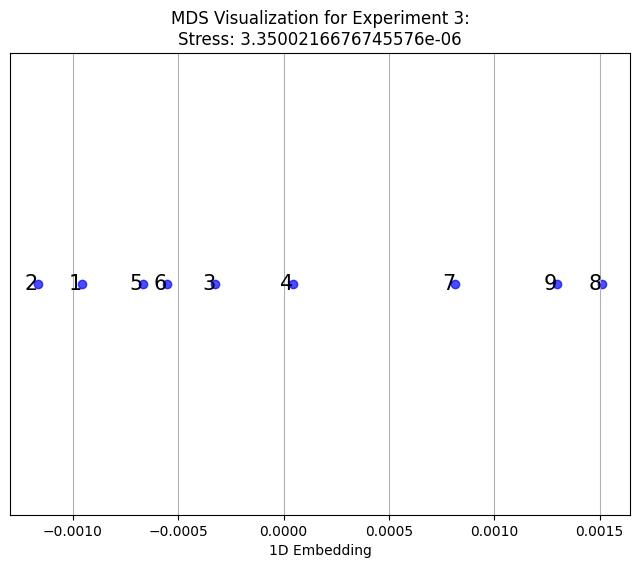

In [60]:
handle_mds(dist_matrix, "Experiment 3", n_comp = 1)

## Experiment 4


In [61]:
def get_a_random_pic_for_exp4(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/{shape}/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [62]:
def createNumerosityDistanceMatrix_Exp4(model, processor, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)
    shape_dict = {i: random.choice(shapes) for i in range(1, 10)}
    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess

            A = random.choice(['A1','A2','A3','A4','A5'])
            img_path = get_a_random_pic_for_exp4(A,i,shape_dict[i])
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_embeddings(img_inputs["pixel_values"])[0]
                global_vector = img_embeddings.mean(dim=(1, 2))
            temp_vectors.append(global_vector.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [63]:
dist_matrix = createNumerosityDistanceMatrix_Exp4(model,processor)

(256,)




Distance Effect
Pearsons correlation: -0.6150398393369889
Fitted parameters:
Slope -0.0002713317951174854
Intercept 0.9999274181924305


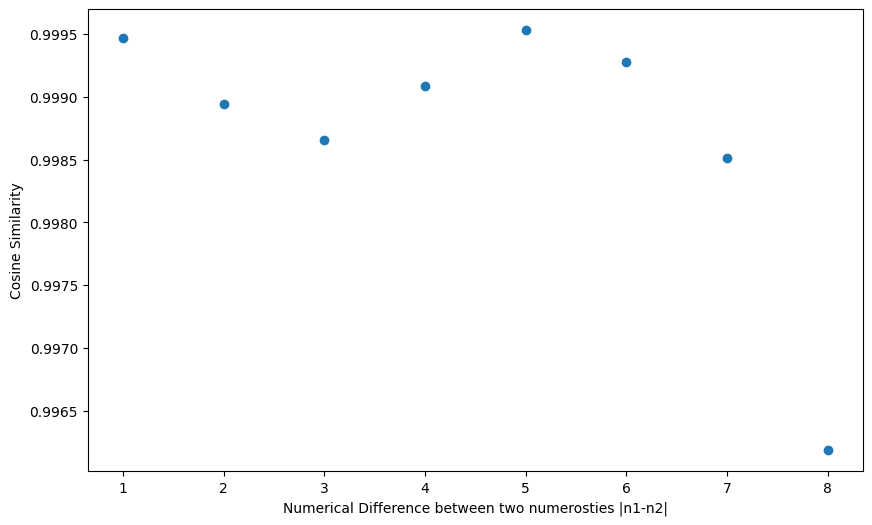

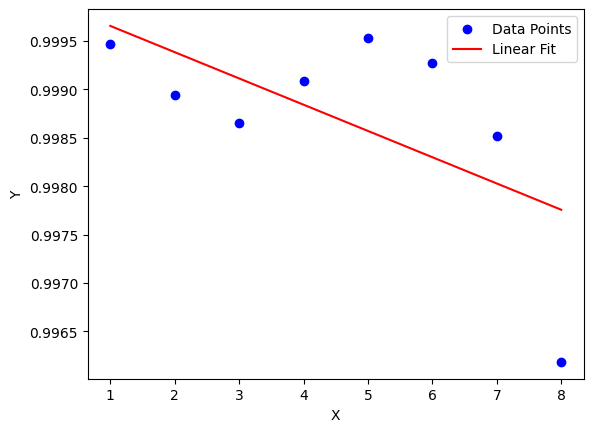

In [64]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: -0.5889881899294483
Fitted parameters:
Slope -0.00012038772389326369
Intercept 0.9995616586384725


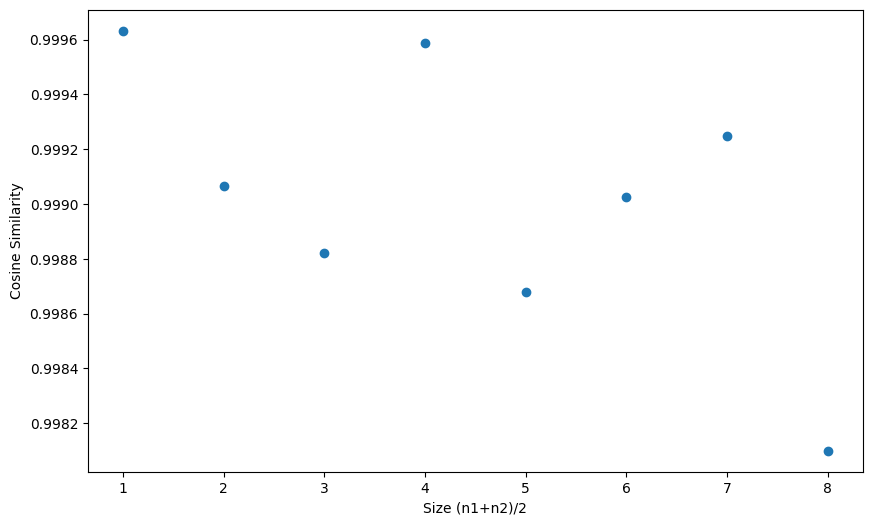

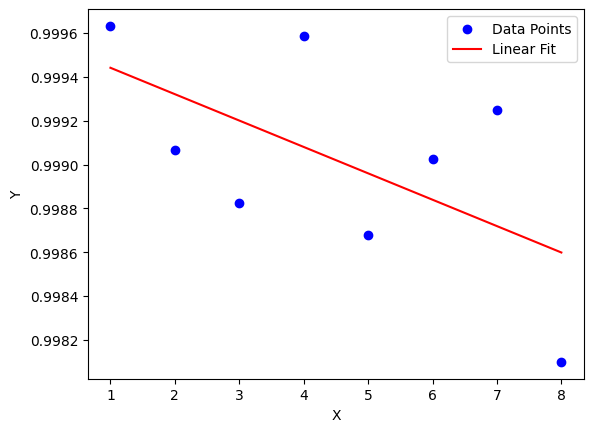

In [65]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.36019860856266817
R-squared value = 0.1297306296881794


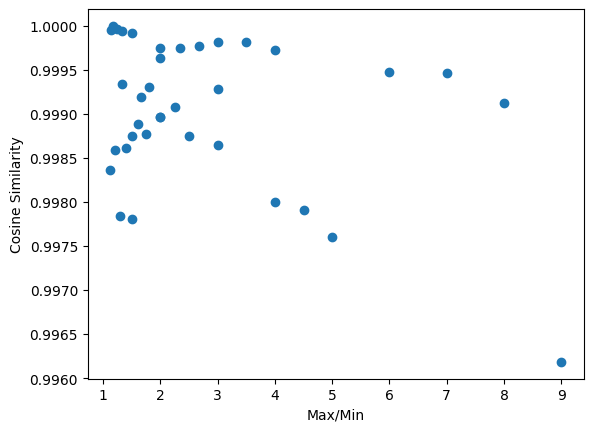

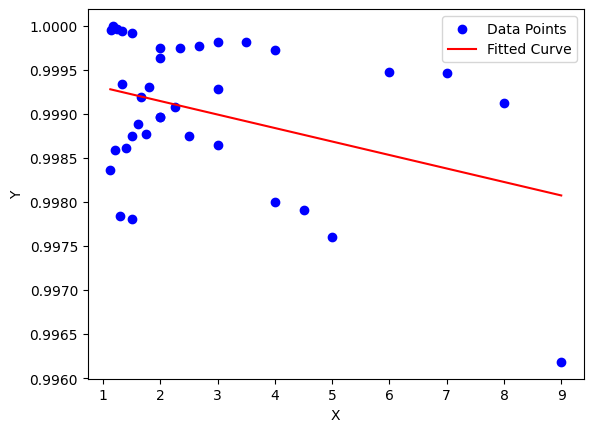

In [66]:
ratio_effect(dist_matrix)

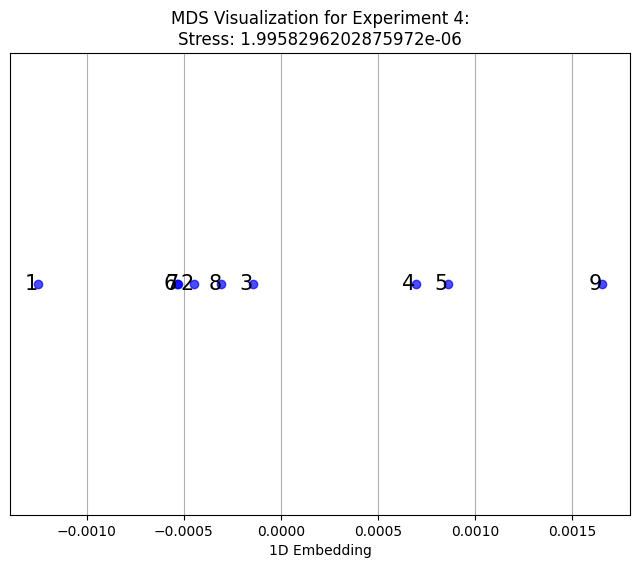

In [67]:
handle_mds(dist_matrix, "Experiment 4", n_comp = 1)

### Experiment 5

In [12]:
def get_a_random_pic_for_exp5(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Random shape random area/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [13]:
def createNumerosityDistanceMatrix_Exp5(model, processor, device="cuda",M=60,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            shape = random.choice(['Equal area squares','Equal area circles','Equal area triangles'])
            A = random.choice(['A1','A2','A3','A4','A5'])
            img_path = get_a_random_pic_for_exp5(A,i,shape)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_embeddings(img_inputs["pixel_values"])[0]
                global_vector = img_embeddings.mean(dim=(1, 2))
            temp_vectors.append(global_vector.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [14]:
dist_matrix = createNumerosityDistanceMatrix_Exp5(model,processor)

(256,)




Distance Effect
Pearsons correlation: -0.9777146384024785
Fitted parameters:
Slope -0.0004906119563344355
Intercept 1.000750553825883


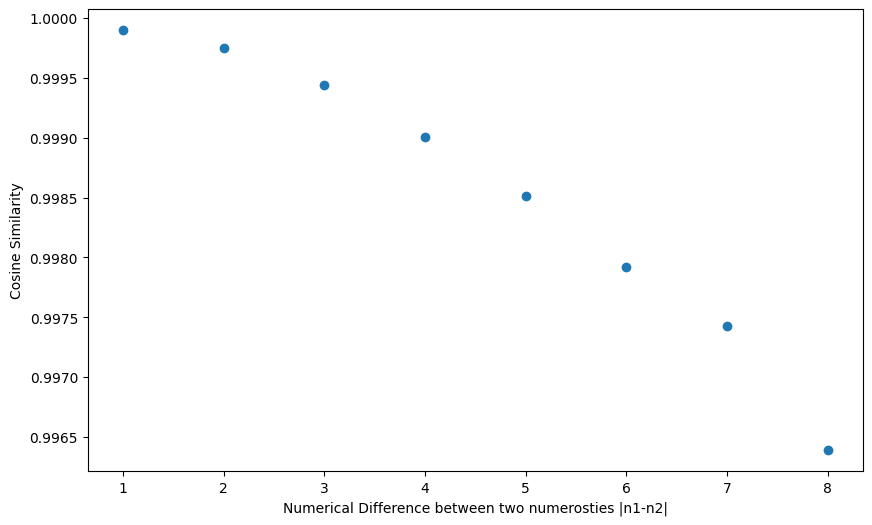

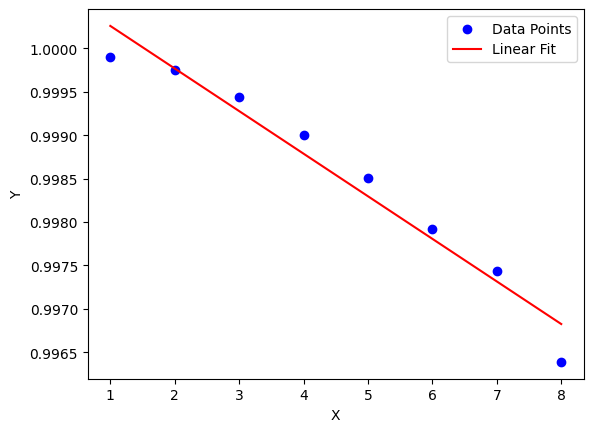

In [15]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.25970605405781283
Fitted parameters:
Slope 5.3644986176976896e-05
Intercept 0.9990809530830709


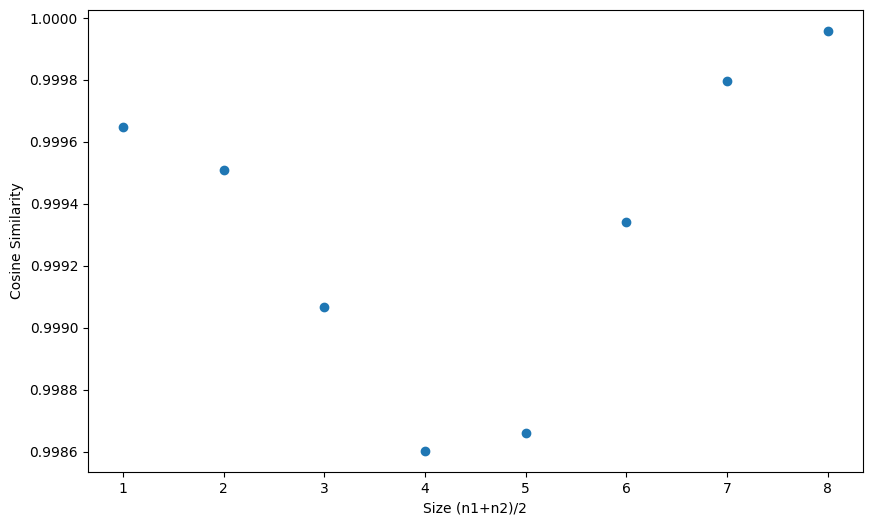

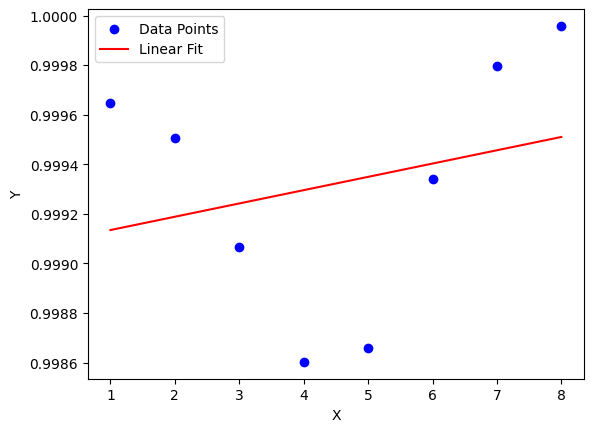

In [16]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.9629982925788234
R-squared value = 0.9307915134080844


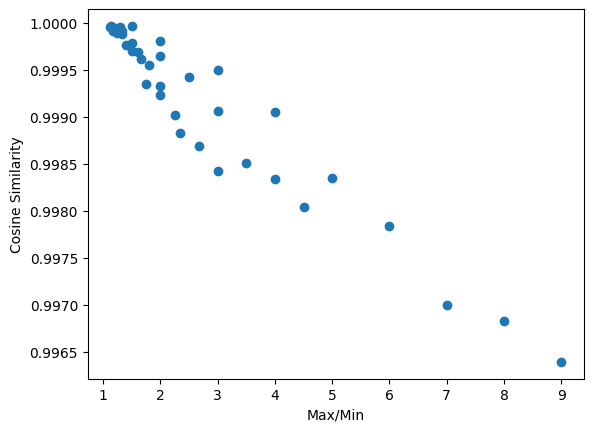

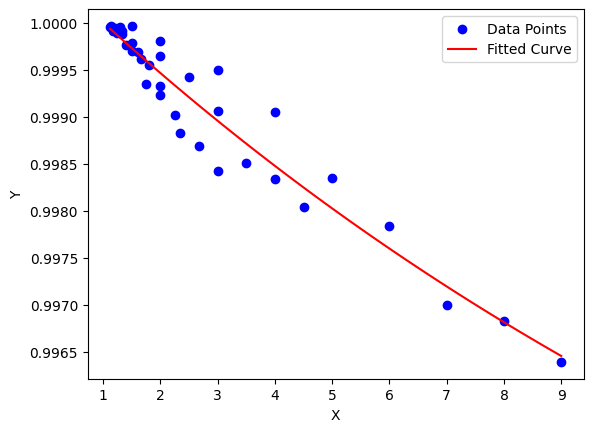

In [17]:
ratio_effect(dist_matrix)

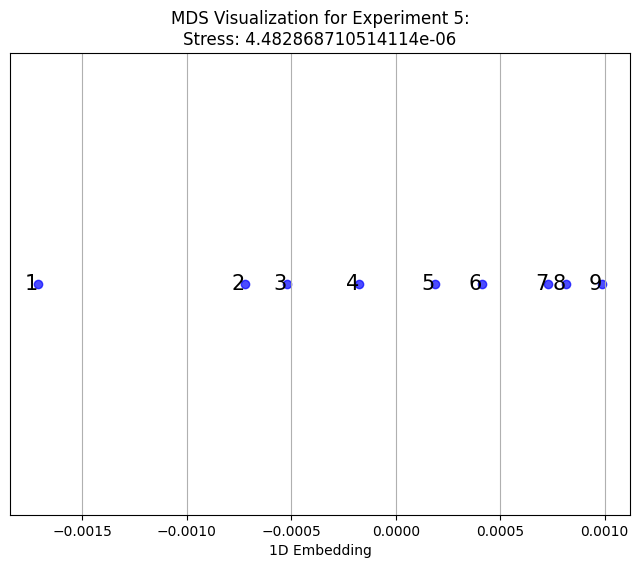

In [18]:
handle_mds(dist_matrix, "Experiment 5", n_comp = 1)

### Naturalistic Images (Exp6)

In [75]:
def get_a_random_pic_for_exp6(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [76]:
def createNumerosityDistanceMatrix_Exp6(model, processor, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp6(i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_embeddings(img_inputs["pixel_values"])[0]
                global_vector = img_embeddings.mean(dim=(1, 2))
            temp_vectors.append(global_vector.cpu().numpy())  # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [77]:
dist_matrix = createNumerosityDistanceMatrix_Exp6(model,processor)

(256,)




Distance Effect
Pearsons correlation: -0.8888317062329467
Fitted parameters:
Slope -0.002949550023087026
Intercept 1.004073137278054


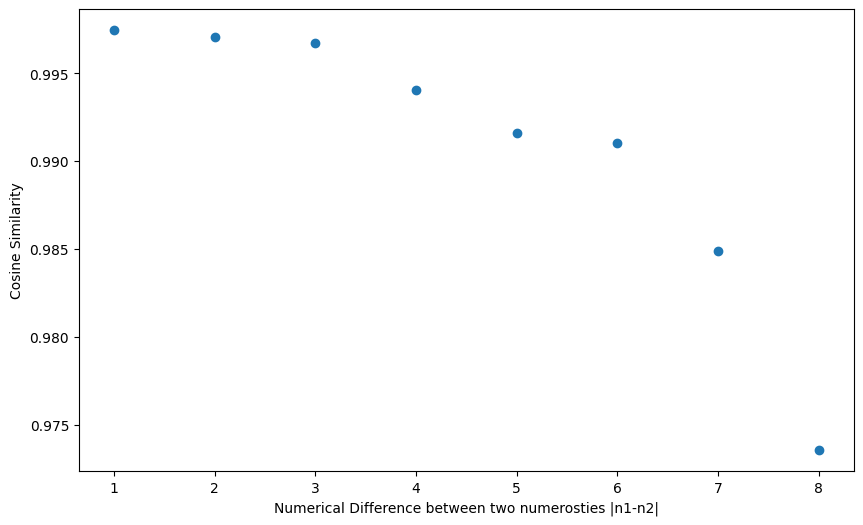

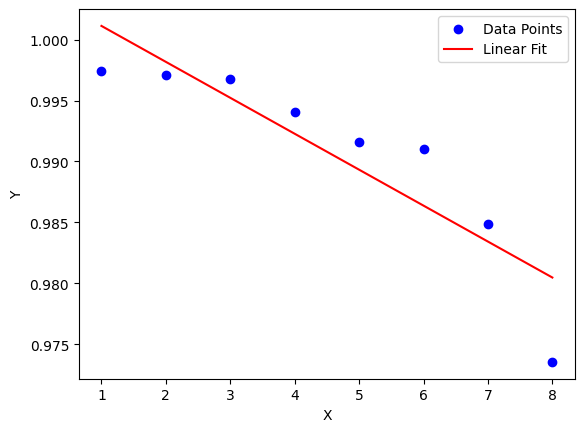

In [78]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: -0.35139567060953714
Fitted parameters:
Slope -0.00023005791937683436
Intercept 0.9959190386189085


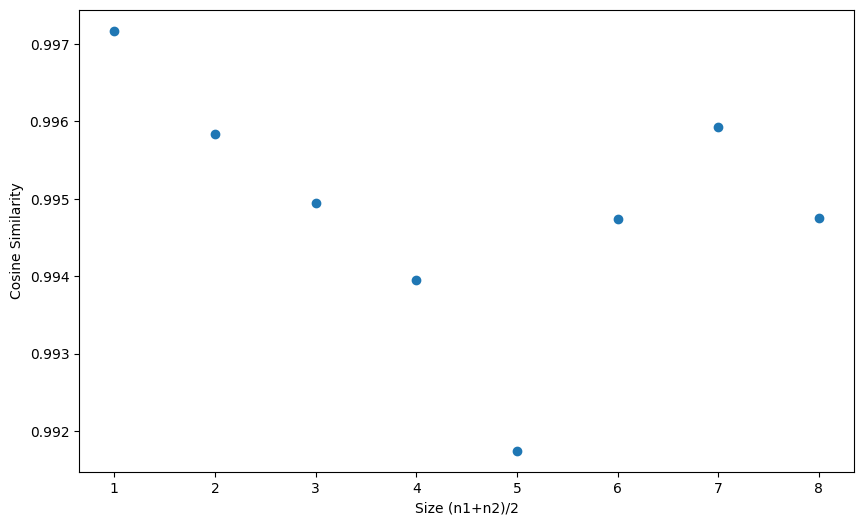

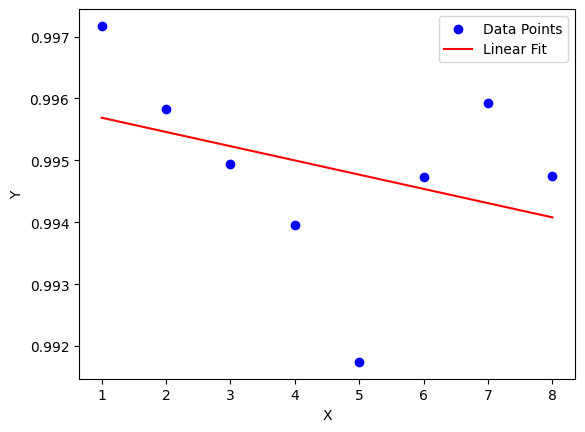

In [79]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.7911275918327376
R-squared value = 0.6258723718243238


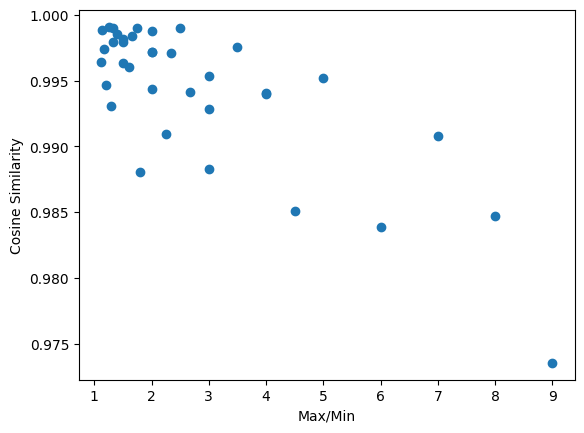

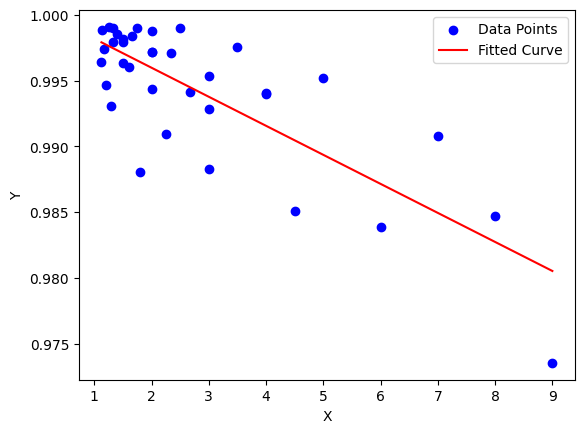

In [80]:
ratio_effect(dist_matrix)

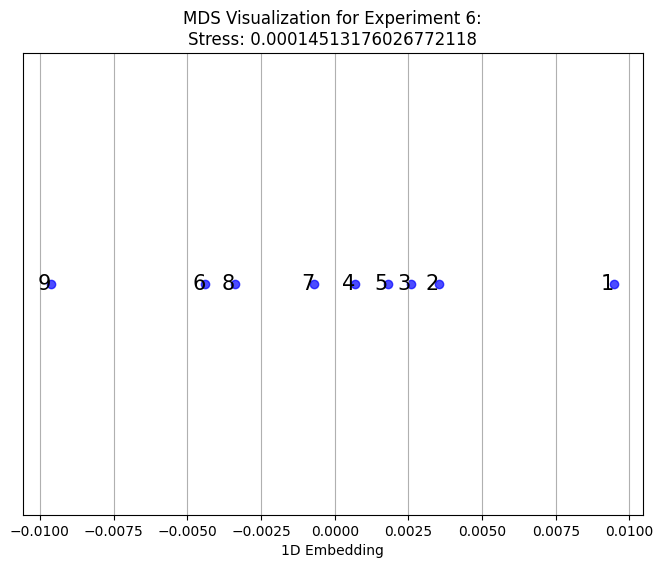

In [81]:
handle_mds(dist_matrix, "Experiment 6", n_comp = 1)

#### Experiments with added background



In [82]:
### Natural images bg plain

def get_a_random_pic_for_exp7(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images plain_bg/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic

def get_a_random_pic_for_exp8(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images plain_bg_blurred/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


def get_a_random_pic_for_exp9(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images dinner/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


def get_a_random_pic_for_exp10(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images dinner_blurred/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic



In [83]:
def createNumerosityDistanceMatrix_Exp(model, processor,get_image, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_image(i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model.get_image_embeddings(img_inputs["pixel_values"])[0]
                global_vector = img_embeddings.mean(dim=(1, 2))
            temp_vectors.append(global_vector.cpu().numpy())  # Move embedding
            
        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [84]:

exp7 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp7)
exp8 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp8)
exp9 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp9)
exp10 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp10)

(256,)
(256,)
(256,)
(256,)


#### Experiment 7 results



Distance Effect
Pearsons correlation: -0.9809523262900629
Fitted parameters:
Slope -0.0011753811849420596
Intercept 1.0005775969602217


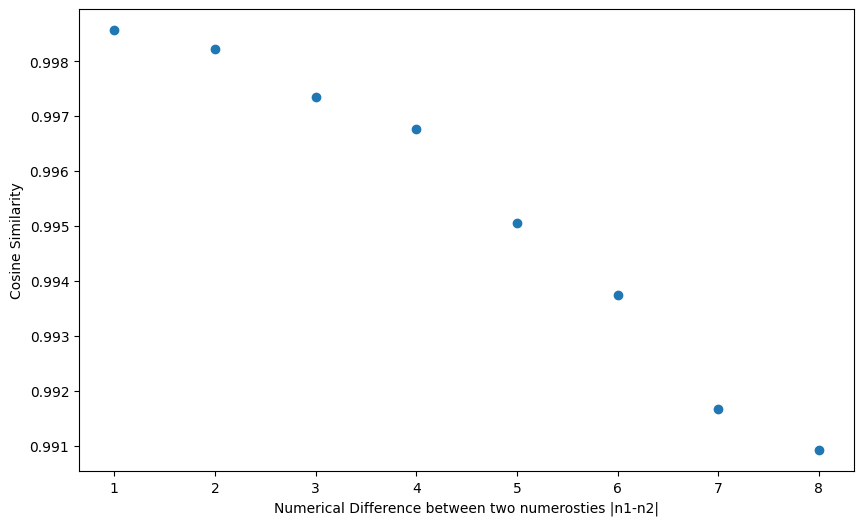

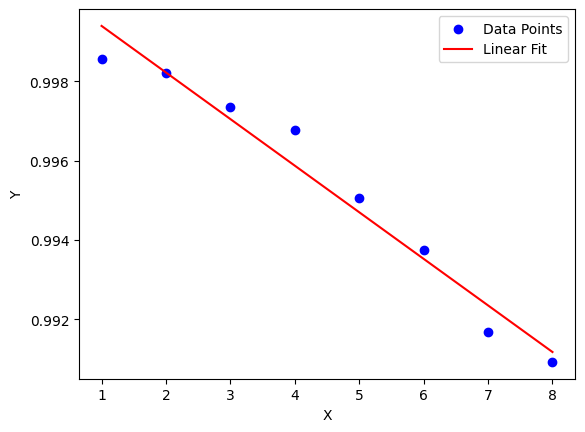

In [85]:
distance_effect(exp7)



Size Effect
Pearsons correlation: -0.06873124747493764
Fitted parameters:
Slope -3.600046967838513e-05
Intercept 0.997414314762062


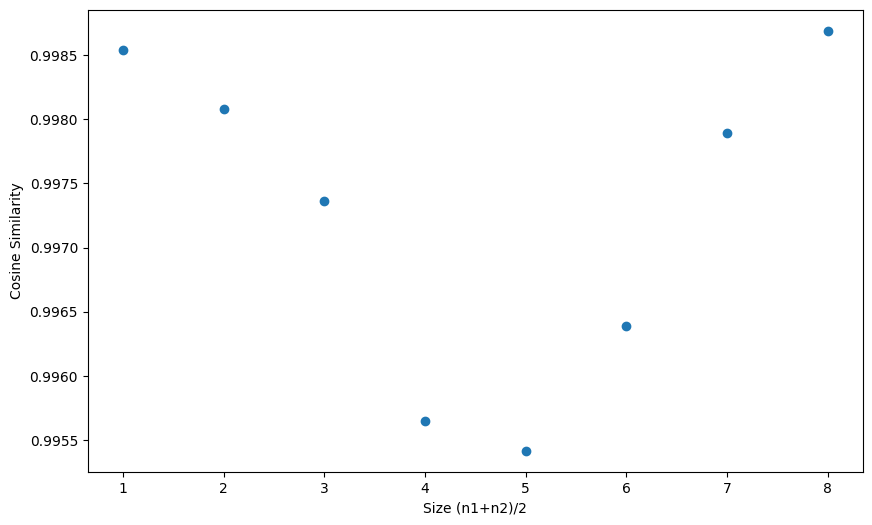

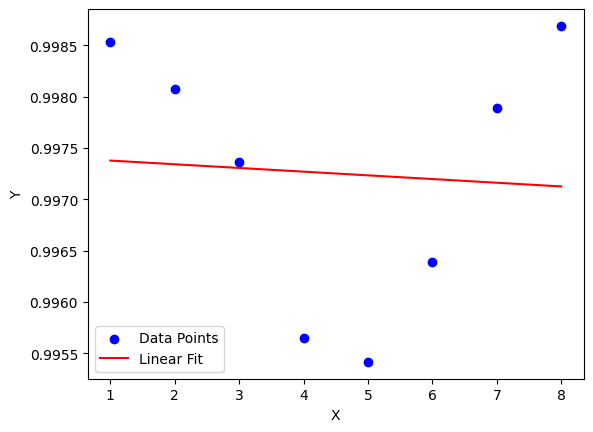

In [86]:
size_effect(exp7)



Ratio Effect
Pearsons correlation: -0.7881502869271902
R-squared value = 0.6211740641148212


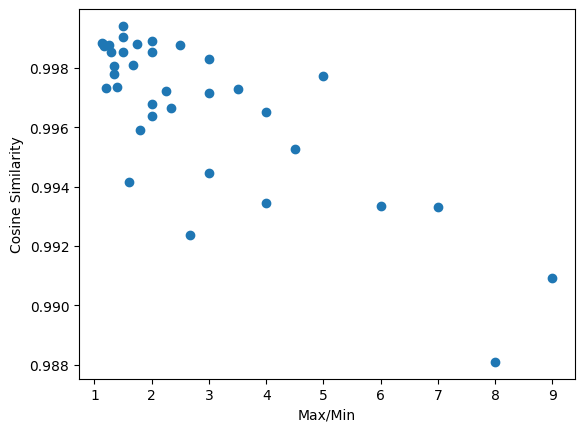

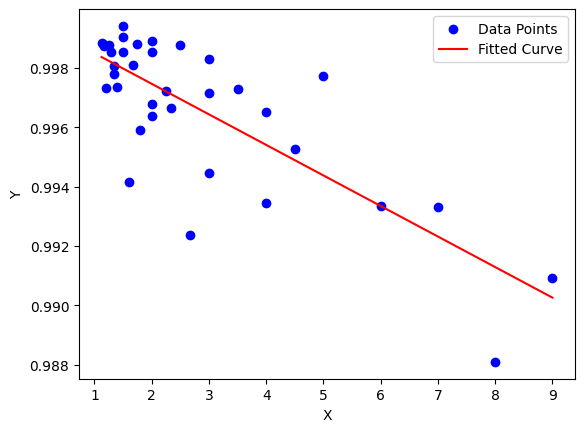

In [87]:
ratio_effect(exp7)

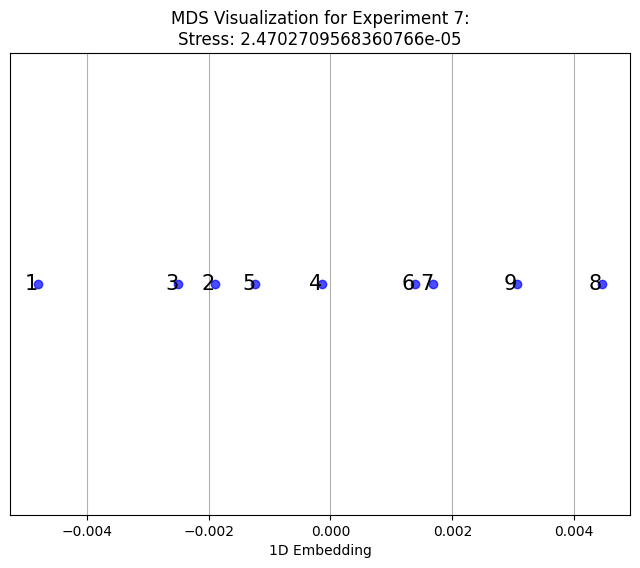

In [88]:
handle_mds(exp7, "Experiment 7", n_comp = 1)

### Experiment 8 results



Distance Effect
Pearsons correlation: -0.9461855966539706
Fitted parameters:
Slope -0.0016481004199203157
Intercept 1.0014882309704412


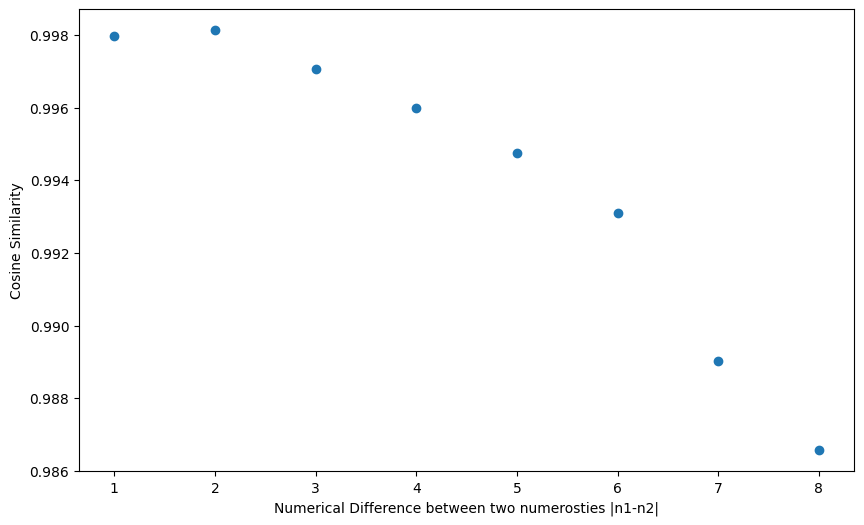

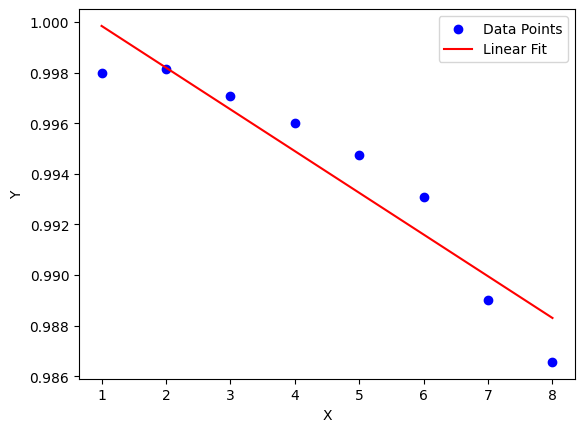

In [89]:
distance_effect(exp8)



Size Effect
Pearsons correlation: 0.09589483043066938
Fitted parameters:
Slope 4.285212411901861e-05
Intercept 0.9962858106611537


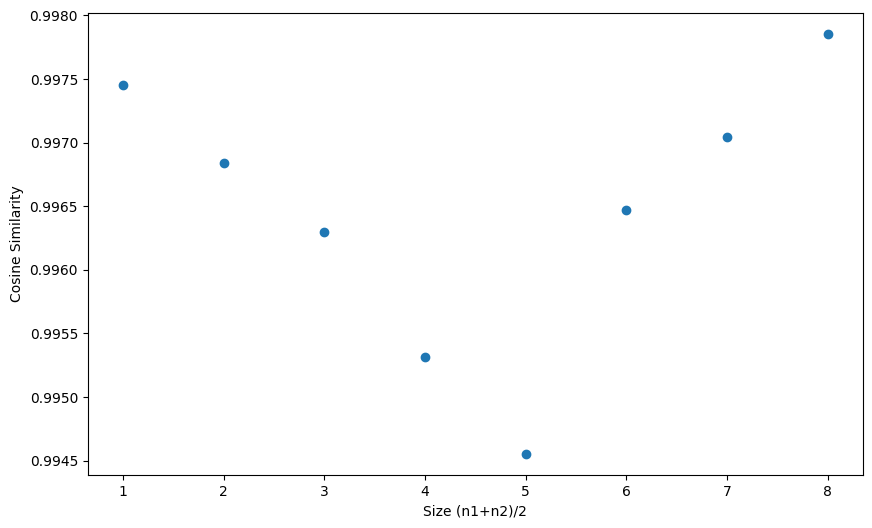

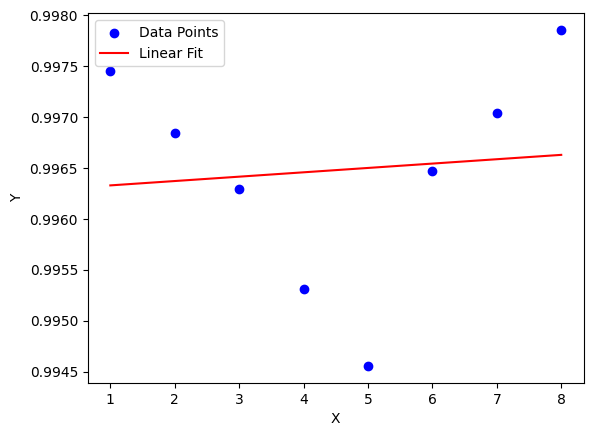

In [90]:
size_effect(exp8)



Ratio Effect
Pearsons correlation: -0.8467294513062046
R-squared value = 0.7169418048471594


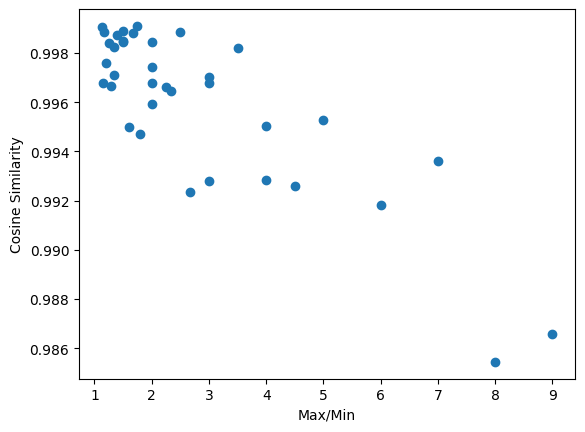

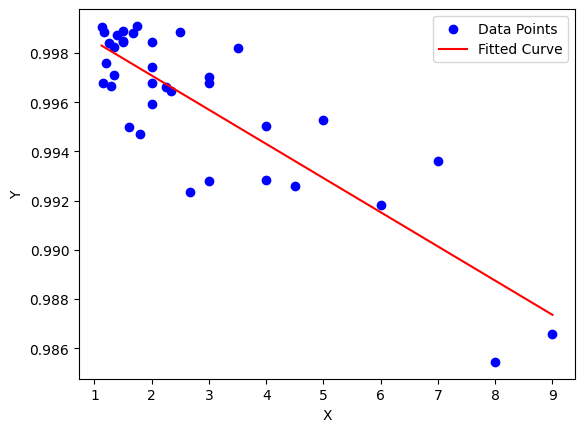

In [91]:
ratio_effect(exp8)

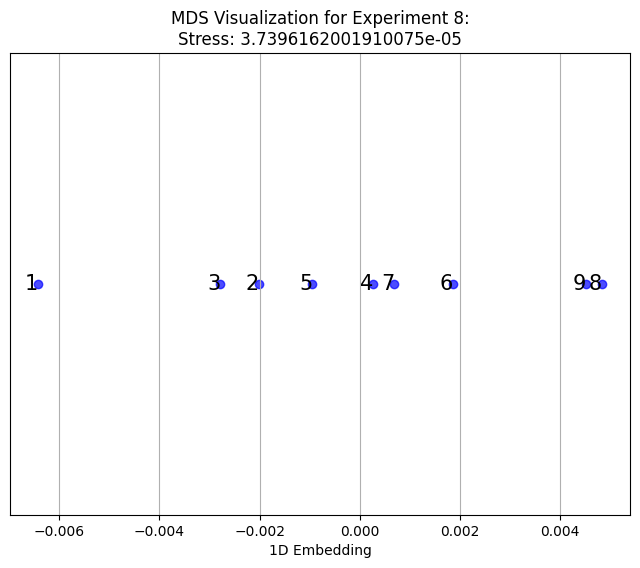

In [92]:
handle_mds(exp8, "Experiment 8", n_comp = 1)

#### Experiment 9



Distance Effect
Pearsons correlation: -0.9514845076722689
Fitted parameters:
Slope -0.000850699831839318
Intercept 0.9997957613395184


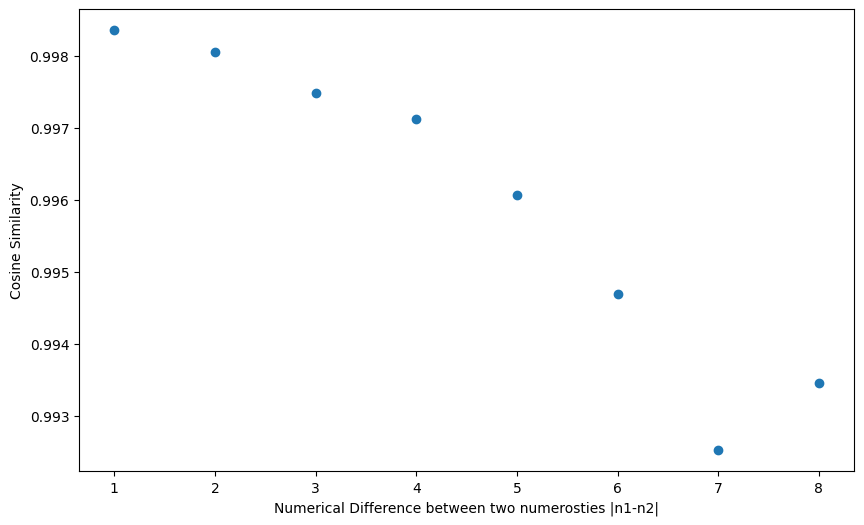

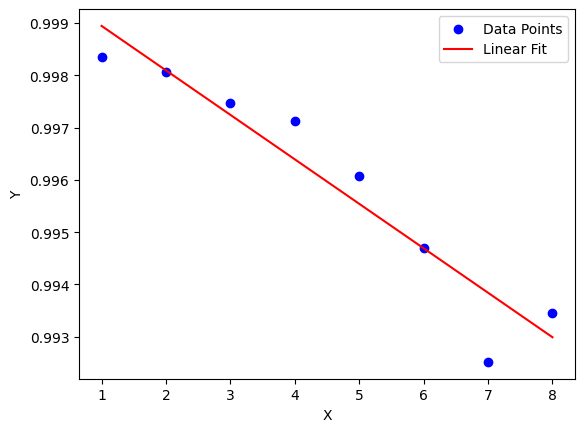

In [93]:
distance_effect(exp9)



Size Effect
Pearsons correlation: 0.07638346469933213
Fitted parameters:
Slope 3.343863991382502e-05
Intercept 0.997166894568878


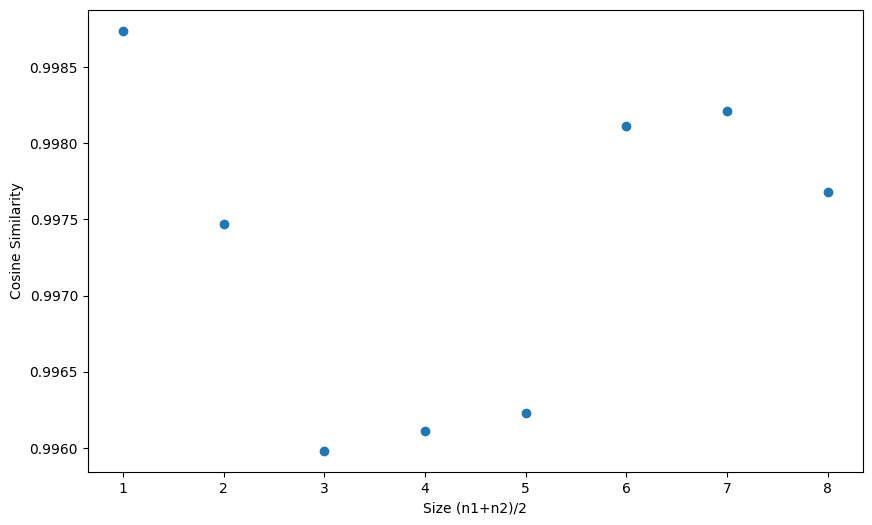

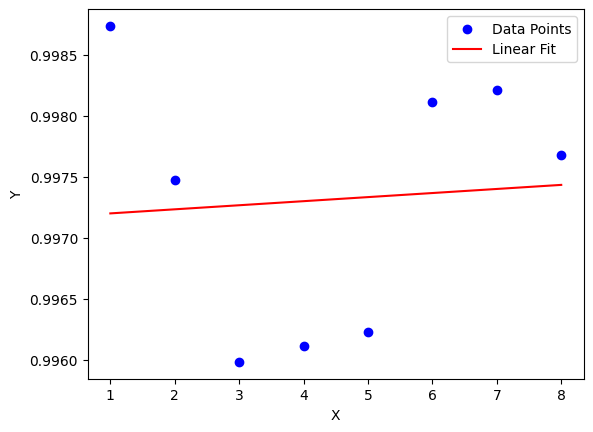

In [94]:
size_effect(exp9)



Ratio Effect
Pearsons correlation: -0.8361634194114405
R-squared value = 0.7199434564739993


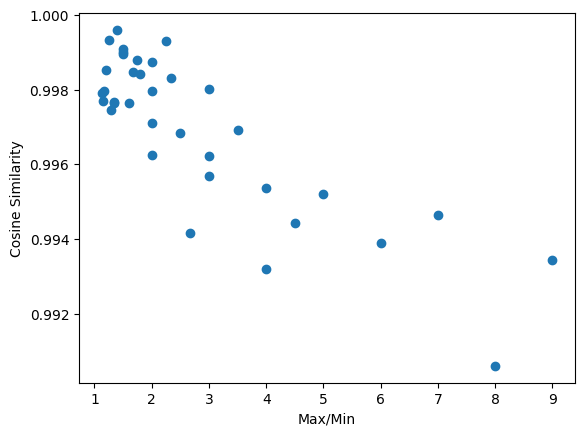

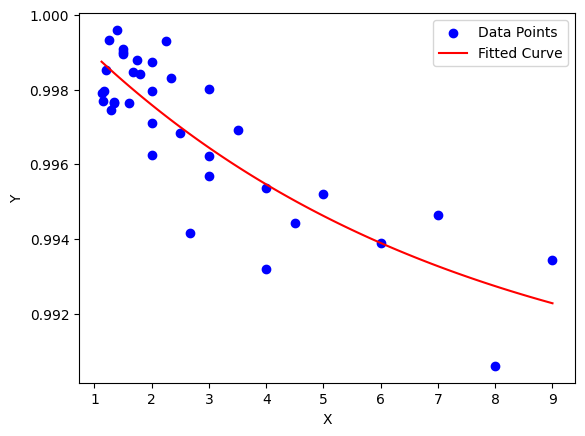

In [95]:
ratio_effect(exp9)

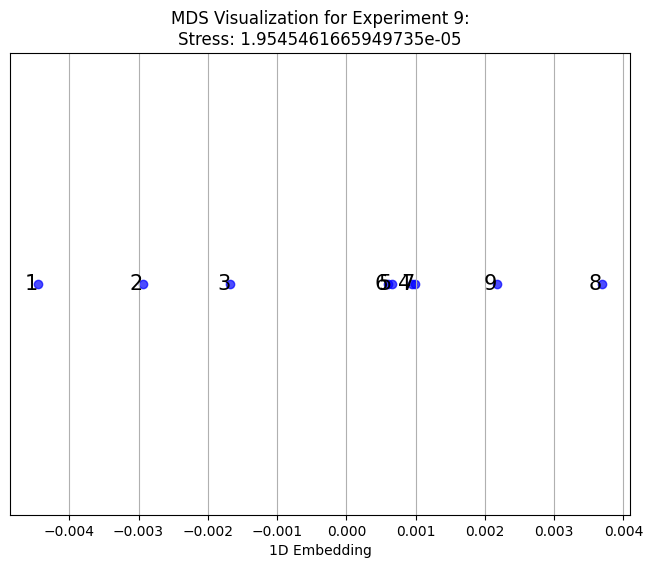

In [96]:
handle_mds(exp9, "Experiment 9", n_comp = 1)

### Experiment 10



Distance Effect
Pearsons correlation: -0.8596949273650019
Fitted parameters:
Slope -0.0007537068989203926
Intercept 0.9987958080458398


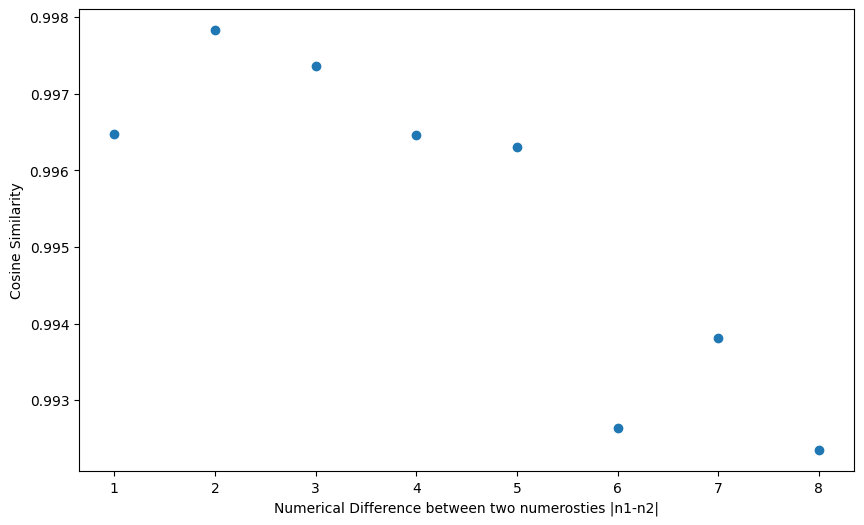

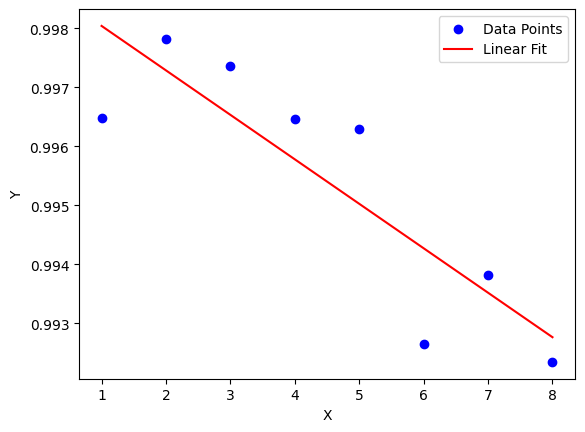

In [97]:
distance_effect(exp10)



Size Effect
Pearsons correlation: 0.6569471462764445
Fitted parameters:
Slope 0.0006703850946256098
Intercept 0.992834637455997


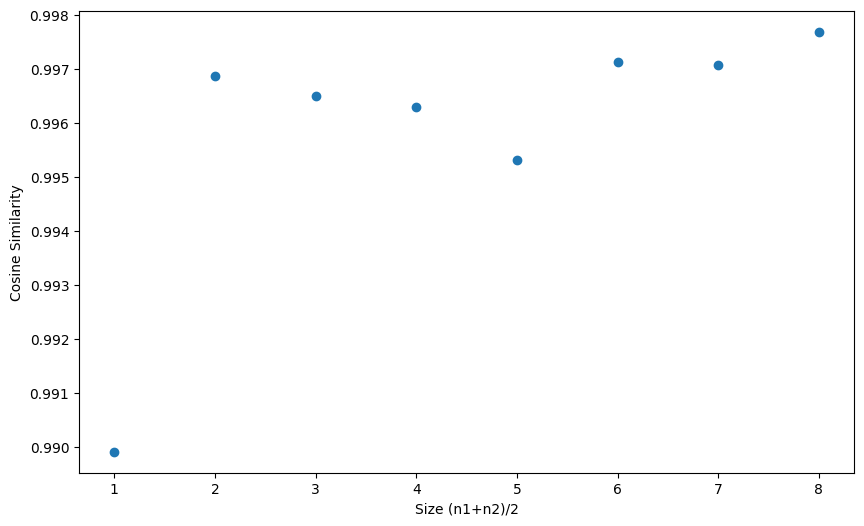

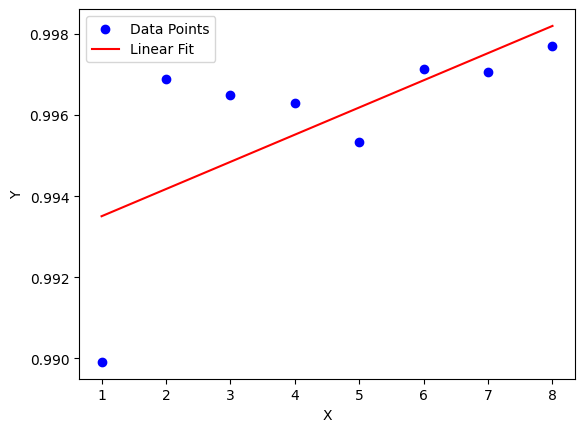

In [98]:
size_effect(exp10)



Ratio Effect
Pearsons correlation: -0.5671483115005567
R-squared value = 0.3356094116948678


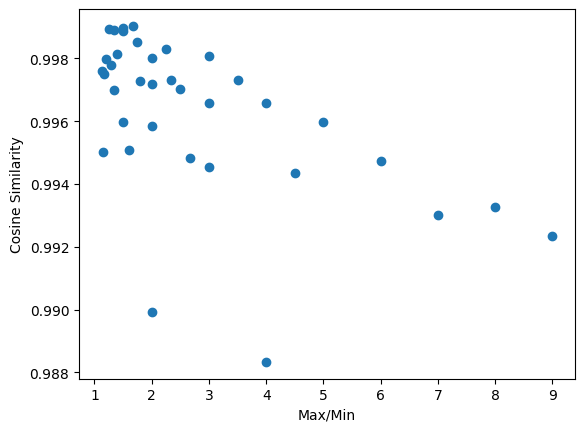

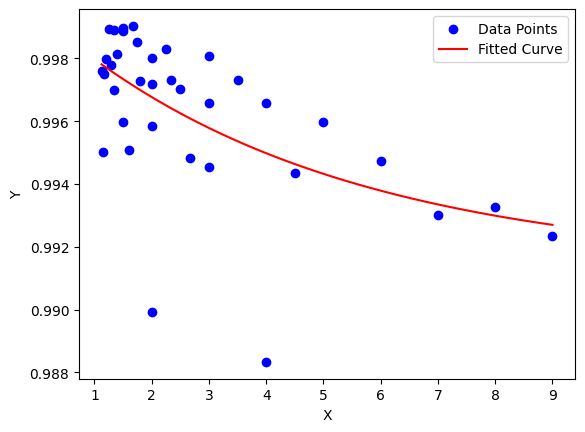

In [99]:
ratio_effect(exp10)

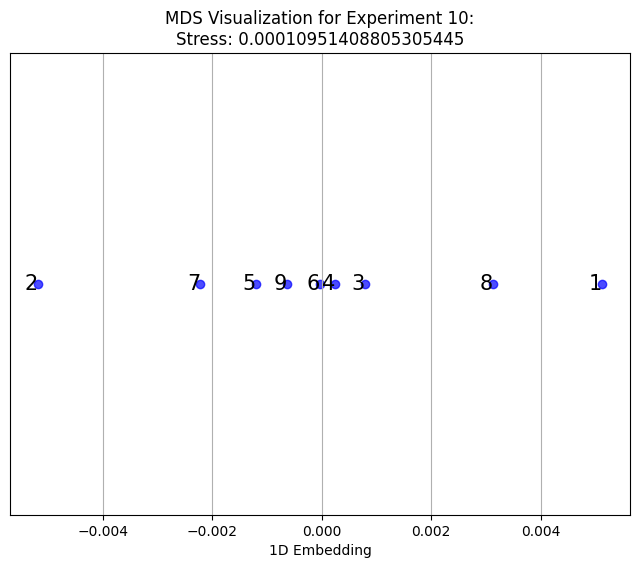

In [100]:
handle_mds(exp10, "Experiment 10", n_comp = 1)